# Improving classification datasets

## Install or upgrade of ekorpkit

```{note}
Install ekorpkit package first.

Set logging level to Warning, if you don't want to see verbose logging.

If you run this notebook in Colab, set Hardware accelerator to GPU.
```
```{toggle}
!pip install -U --pre ekorpkit

exit()
```

In [ ]:
!pip install -U --pre ekorpkit
!pip install -U matplotlib simpletransformers

## Prepare an environment

In [1]:
%config InlineBackend.figure_format='retina'
from ekorpkit import eKonf

eKonf.setLogger("WARNING")
print("version:", eKonf.__version__)
print("is notebook?", eKonf.is_notebook())
print("is colab?", eKonf.is_colab())
print("environment variables:")
eKonf.print(eKonf.env().dict())

version: 0.1.38+40.geb12c43.dirty
is notebook? True
is colab? False
environment variables:
{'CUDA_DEVICE_ORDER': None,
 'CUDA_VISIBLE_DEVICES': None,
 'EKORPKIT_CONFIG_DIR': '/workspace/projects/ekorpkit-book/config',
 'EKORPKIT_DATA_DIR': None,
 'EKORPKIT_LOG_LEVEL': 'WARNING',
 'EKORPKIT_PROJECT': 'ekorpkit-book',
 'EKORPKIT_WORKSPACE_ROOT': '/workspace',
 'KMP_DUPLICATE_LIB_OK': 'TRUE',
 'NUM_WORKERS': 230}


In [2]:
data_dir = "../data/cointax"

## Building `cointax_polarity` dataset

In [3]:
raw_data = eKonf.load_data("cointax.csv", data_dir)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   긍정      478 non-null    object
 1   부정      236 non-null    object
dtypes: object(2)
memory usage: 11.3+ KB


In [4]:
import numpy as np
data = []
for polarity, rows in raw_data.to_dict().items():
    data += [dict(text=text, labels=polarity) for text in rows.values() if text is not np.NaN]
data = eKonf.records_to_dataframe(data)
eKonf.save_data(data, "cointax_rawdata.parquet", data_dir)
data

text labels
0                                     가상자산을 안해서     긍정
1                                기타 자산과 동일하게 적용     긍정
2                                         그냥 저냥     긍정
3                                   부당이익에 대한 해소     긍정
4    땀흘려 일하지 않고 쉽게 돈 벌려는 사회적인 풍토를 근절해야 된다고 생각해서     긍정
..                                          ...    ...
709                                 소득과세가 너누 높다    부정 
710                  주식 거래세 수수료보다도 너무 높다고 생각하기에    부정 
711                                  너무 심하다고 생각    부정 
712                                      ......    부정 
713                        수익의 20%는 너무 많다고 생각한다    부정 

[714 rows x 2 columns]

In [5]:
cfg = eKonf.compose("dataset=dataset_build")
cfg.name = "cointax_polarity_kr"
cfg.data_dir = data_dir
cfg.data_file = "cointax_rawdata.parquet"
cfg.force.build = True
cfg.pipeline.split_sampling.stratify_on = "labels"
cfg.pipeline.split_sampling.random_state = 1234
cfg.pipeline.split_sampling.test_size = 0.2
cfg.pipeline.split_sampling.dev_size = 0.1
cfg.pipeline.reset_index.drop_index = False
cfg.verbose = False
cointax_polarity_ds = eKonf.instantiate(cfg)
cointax_polarity_ds.persist()

INFO:ekorpkit.base:Loaded .env from /workspace/projects/ekorpkit-book/config/.env
INFO:ekorpkit.base:setting environment variable CACHED_PATH_CACHE_ROOT to /workspace/.cache/cached_path
INFO:ekorpkit.base:setting environment variable KMP_DUPLICATE_LIB_OK to TRUE
INFO:ekorpkit.base:Applying pipe: functools.partial(<function load_dataframe at 0x7f86d4c3d040>)
INFO:ekorpkit.base:Applying pipe: functools.partial(<function reset_index at 0x7f86d4c3c280>)
INFO:ekorpkit.base:Applying pipe: functools.partial(<function split_sampling at 0x7f86d4c34e50>)
INFO:ekorpkit.base:Using batcher with minibatch size: 3


apply len_bytes to num_bytes:   0%|          | 0/171 [00:00<?, ?it/s]

INFO:ekorpkit.base:Using batcher with minibatch size: 1


apply len_bytes to num_bytes:   0%|          | 0/58 [00:00<?, ?it/s]

INFO:ekorpkit.base:Using batcher with minibatch size: 1


apply len_bytes to num_bytes:   0%|          | 0/143 [00:00<?, ?it/s]

## Loading `cointax_polarity` dataset

In [3]:
ds_cfg = eKonf.compose('dataset')
ds_cfg.name = 'cointax_polarity_kr'
ds_cfg.data_dir = data_dir
ds = eKonf.instantiate(ds_cfg)
labels = list(ds.splits['train'].labels.unique())
print(labels)

INFO:ekorpkit.base:Loaded .env from /workspace/projects/ekorpkit-book/config/.env
INFO:ekorpkit.base:setting environment variable CACHED_PATH_CACHE_ROOT to /workspace/.cache/cached_path
INFO:ekorpkit.base:setting environment variable KMP_DUPLICATE_LIB_OK to TRUE


['긍정', '부정 ']


In [5]:
ds.data.tail(1)

id             text labels split
713  379  소득이 있으면 과세하여야된다     긍정   dev

## Cross validation of `cointax_polarity_kr` dataset

INFO:ekorpkit.base:Calling eval


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy:  0.7202797202797203
Precison:  0.7680942606315742
Recall:  0.7202797202797203
F1 Score:  0.6484819528297789
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

          긍정       0.71      0.99      0.83        96
         부정        0.89      0.17      0.29        47

    accuracy                           0.72       143
   macro avg       0.80      0.58      0.56       143
weighted avg       0.77      0.72      0.65       143



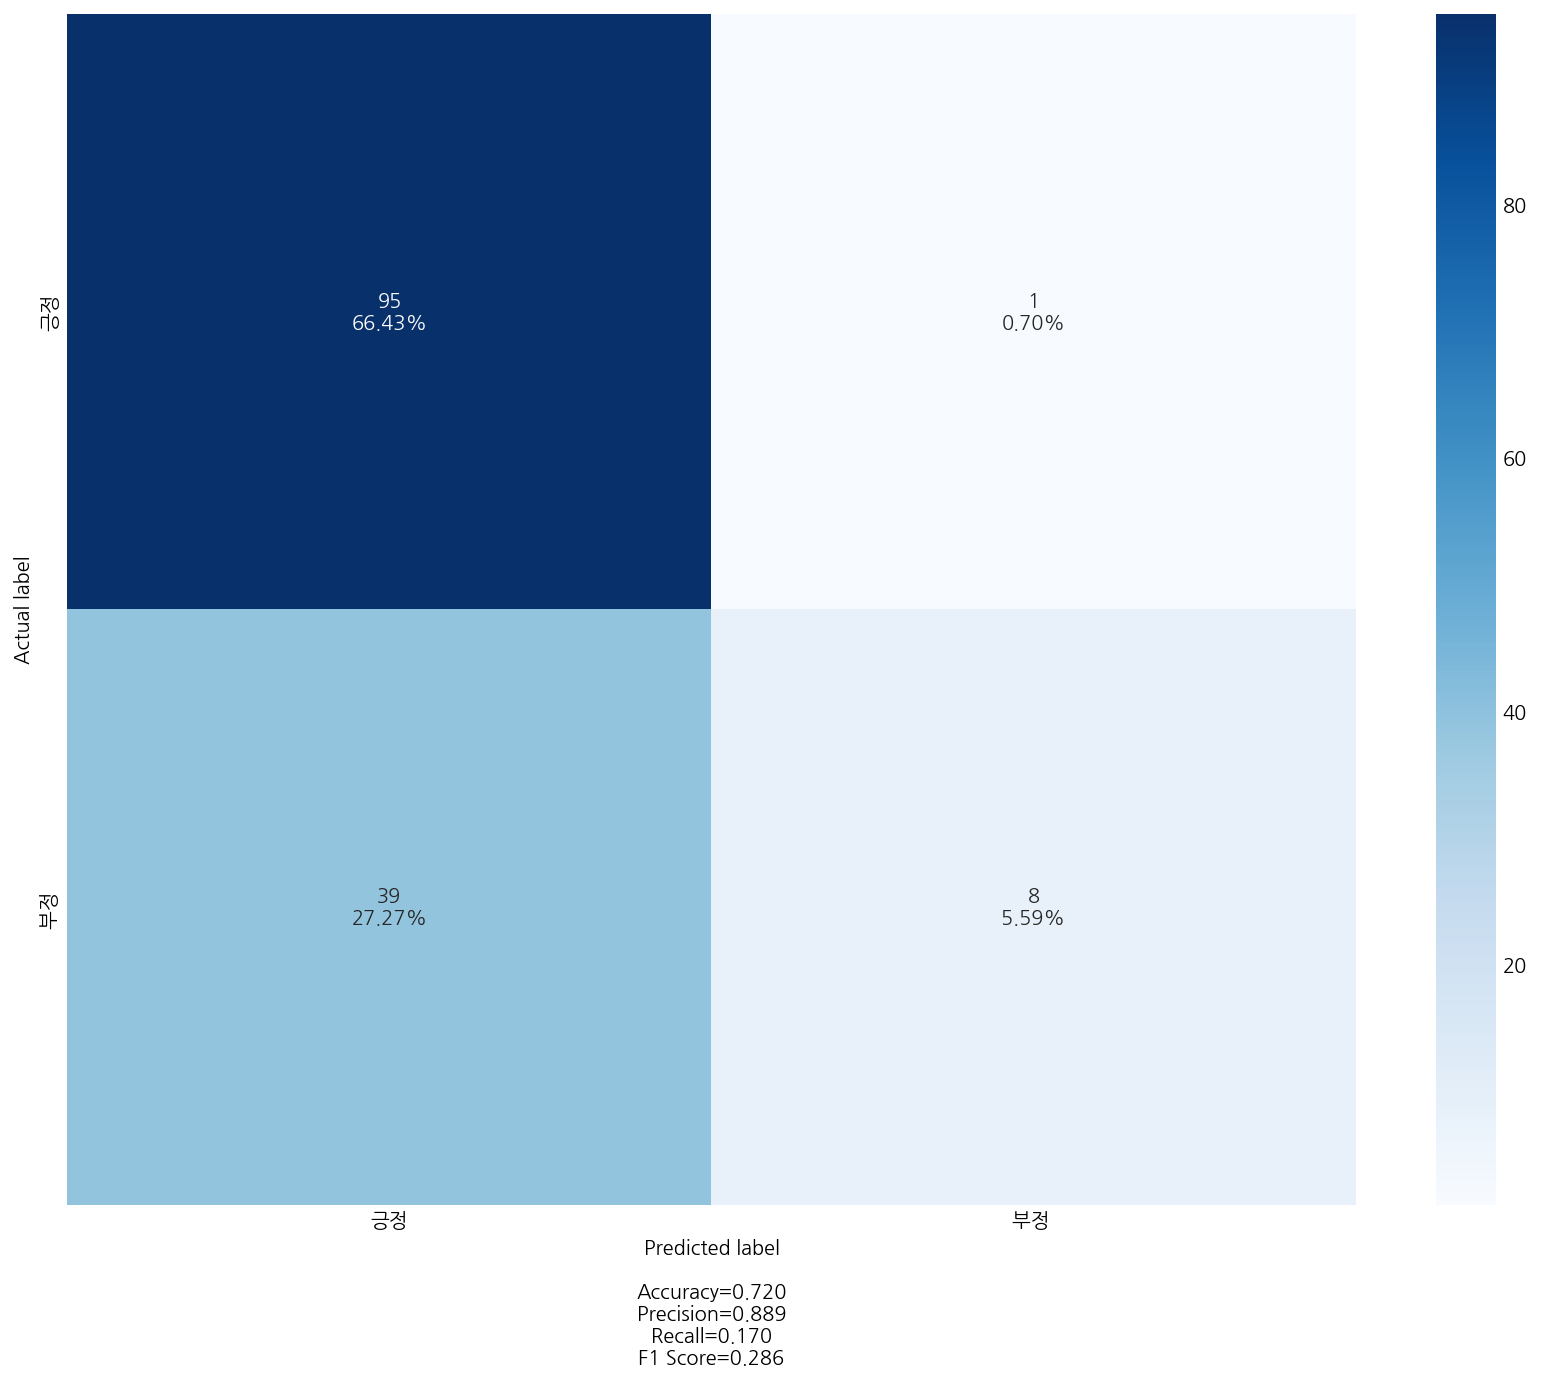

In [6]:
overrides=[
    '+model/transformer=classification',
    '+model/transformer/pretrained=ekonelectra-base',
]
model_cfg = eKonf.compose('model/transformer=classification', overrides)
model_cfg.name = "cointax_polarity_kr_improved"
model_cfg.dataset = ds_cfg
model_cfg.verbose = False
model_cfg.config.num_train_epochs = 2
model_cfg.config.max_seq_length = 256
model_cfg.config.train_batch_size = 32
model_cfg.config.eval_batch_size = 32
model_cfg._method_ = ['train', 'eval']
model_cfg.model.eval.visualize.plot.figure.figsize = (12,10)
model = eKonf.instantiate(model_cfg)

In [31]:
cv_preds = model.cross_val_predict(cv=5)
eKonf.save_data(cv_preds, "cointax_polarity_kr_cv_preds.parquet", data_dir)

Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelectra-base-discriminator and are newly initializ

  0%|          | 0/450 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running Epoch 0 of 2:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelectra-base-discriminator and are newly initializ

  0%|          | 0/450 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running Epoch 0 of 2:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelectra-base-discriminator and are newly initializ

  0%|          | 0/450 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running Epoch 0 of 2:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelectra-base-discriminator and are newly initializ

  0%|          | 0/450 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running Epoch 0 of 2:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelectra-base-discriminator and are newly initializ

  0%|          | 0/451 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running Epoch 0 of 2:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

## Use rubrix to find potential label errors

In [32]:
rb_cfg = eKonf.compose('model/rubrix')
rb_cfg.workspace = 'tax'
rb_cfg.auto.init = True
rb = eKonf.instantiate(rb_cfg)


INFO:ekorpkit.base:Loaded .env from /workspace/projects/ekorpkit-book/config/.env
INFO:ekorpkit.base:Loaded .env from /workspace/projects/ekorpkit-book/config/.env


In [33]:
rb.get_workspace()

'tax'

In [34]:
cv_preds = eKonf.load_data("cointax_polarity_kr_cv_preds.parquet", data_dir)

In [35]:
records = rb.create_records_from_cv_preds(
    cv_preds,
)
records[0]

TextClassificationRecord(text='필요하다', inputs={'text': '필요하다'}, prediction=[('긍정', 0.729790130571998), ('부정 ', 0.27020986942800196)], prediction_agent=None, annotation='긍정', annotation_agent=None, multi_label=False, explanation=None, id=None, metadata={'id': 348, 'split': 'train'}, status='Validated', event_timestamp=None, metrics=None, search_keywords=None)

In [36]:
# get records with potential label errors
records_with_label_error = rb.find_label_errors(records)
records_with_label_error[0]

TextClassificationRecord(text='가상자산은 유동성이 많으므로 과세하는 것은 소급 적용되어야 함', inputs={'text': '가상자산은 유동성이 많으므로 과세하는 것은 소급 적용되어야 함'}, prediction=[('긍정', 0.7823715659587565), ('부정 ', 0.21762843404124352)], prediction_agent=None, annotation='부정 ', annotation_agent=None, multi_label=False, explanation=None, id=None, metadata={'id': 660, 'split': 'train', 'label_error_candidate': 0}, status='Validated', event_timestamp=None, metrics=None, search_keywords=None)

In [37]:
len(records_with_label_error)

16

In [20]:
# uncover label errors in the Rubrix web app
rb.log(records_with_label_error, "cointax_polarity_kr_label_errors")

  0%|          | 0/20 [00:00<?, ?it/s]

20 records logged to http://ekorpkit-book:6900/datasets/tax/cointax_polarity_kr_label_errors


## Saving the re-labelled dataset

In [26]:
relabelled_dataset = rb.load("cointax_polarity_kr_label_errors")

In [27]:
for split, data in ds._splits.items():
    data = rb.update_label_errors(data, relabelled_dataset, split=split)
    ds._splits[split] = data

In [28]:
len(ds.data[ds.data.labels != ds.data.original_labels])

0

In [29]:
ds.save_as("cointax_polarity_kr_improved")
ds_cfg.name = "cointax_polarity_kr_improved"
ds = eKonf.instantiate(ds_cfg)
labels = list(ds.splits['train'].labels.unique())
print(labels)

INFO:ekorpkit.base:Using batcher with minibatch size: 3


apply len_bytes to num_bytes:   0%|          | 0/169 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

INFO:ekorpkit.base:Using batcher with minibatch size: 1


apply len_bytes to num_bytes:   0%|          | 0/58 [00:00<?, ?it/s]

INFO:ekorpkit.base:Using batcher with minibatch size: 1


apply len_bytes to num_bytes:   0%|          | 0/139 [00:00<?, ?it/s]

['긍정', '부정 ']


In [25]:
ds.data_dir

'../data/cointax/cointax_polarity_kr_improved'